In [6]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams["image.composite_image"]=False
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from numpy.fft import rfft, irfft, fft, ifft

import psrchive
import residuals

import pipe
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
template = "template-work/56412.76_GBT_1400.rmset.scrunch.sm"
#template = "template-work/56736.85_AO_1400.profile.psrsmooth"
#template = "template-work/56070.64_AO_430.tscrunch.fscrunch.sm"
#processing_name = "toa-testing-2"
processing_name = "sband"
#processing_name = "wideband"
toa_name = "mueller"

In [8]:
#observation = "data/obs/56117.50_AO_1400"
#pipe.process_observation(observation, processing_name,
#                         work_dir="/tmp/triple-pipeline-test-6")
#pipe.process_observation(observation, processing_name,
#                         toa_bw=100, toa_time=60.)
#observation = "data/obs/56262.88_WSRT_1400"
#observation = "data/obs/56496.15_WSRT_1400"
observation = "data/obs/56768.75_AO_2000"
#pipe.process_observation(observation, processing_name,
#                         toa_bw=100.,
#                         toa_time=600.)
#observation = "data/obs/56494.49_GBT_1400"
#pipe.process_observation(observation, processing_name)
#pipe.process_observation(observation, processing_name,
#                         toa_bw=100, toa_time=60.)
#observation = "data/obs/56070.64_AO_430"
#pipe.process_observation(observation, processing_name,
#                        toa_bw=100./8, toa_time=60.)
#observation = "data/obs/56479.20_WSRT_350"
#pipe.process_observation(observation, processing_name,
#                         toa_time=1200., toa_bw=30.)
#observation = "data/obs/56768.79_AO_2000"
#pipe.process_observation(observation, processing_name,
#                         toa_bw=100, toa_time=60.)

## Implementation

Now moved to `pipe.py` and updated, so this code is stale.

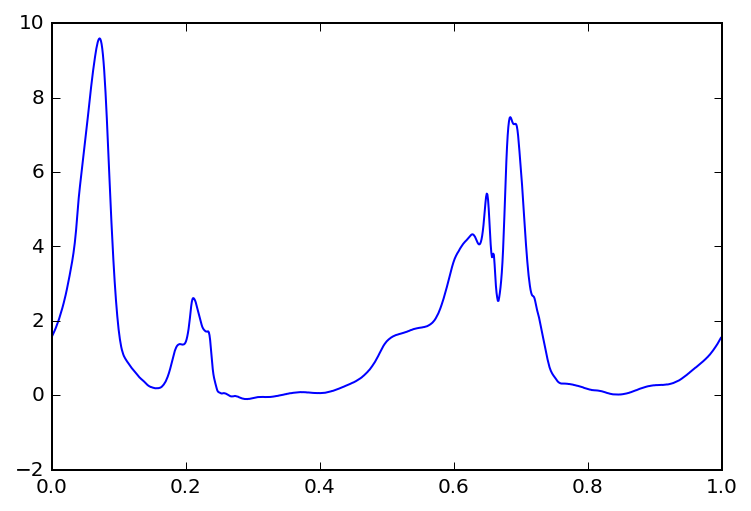

In [4]:
T = psrchive.Archive_load(template)
T.dedisperse()
T.pscrunch()
T.remove_baseline()
t_values = T.get_data()[0,0,0,:]
t_phases = np.linspace(0,1,len(t_values),endpoint=False)
plt.plot(t_phases,t_values)

In [5]:
with open(join(observation,"meta.pickle"),"rb") as f:
    meta = pickle.load(f)
print meta["tstart"], meta["mjd"], meta["tend"]
with open(join(observation,processing_name,"process.pickle"),"rb") as f:
    meta = pickle.load(f)
print meta["tstart"], meta["mjd"], meta["tend"]
print meta["bw"]

56768.7382618 56768.747091 56768.7559202
56768.7382618 56768.747091 56768.7559202
-400.0


In [898]:
summary = dict(meta=meta)

data/obs/56496.15_WSRT_1400/toa-testing-2/scrunch_0000.ar
24 24


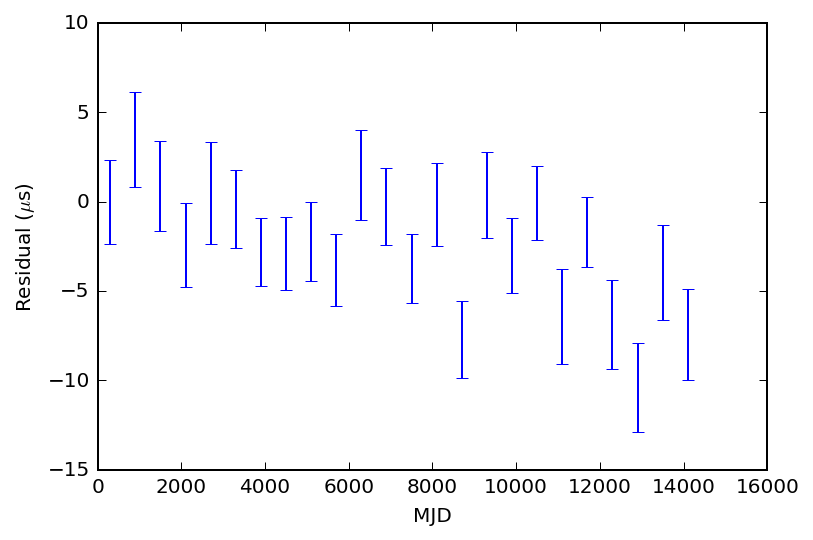

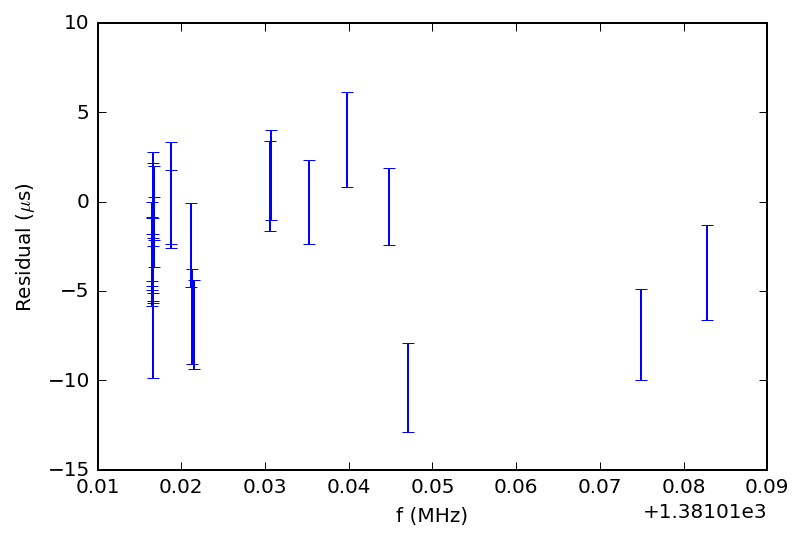

In [899]:
sf, = sorted(glob(join(observation,processing_name,"scrunch_*.ar")))
print sf

pat_output = subprocess.check_output(["pat", 
                             "-s", template,
                             "-f", "tempo2 IPTA",
                             sf])

topo_toa = []
toa_info = []
for l in pat_output.split("\n"):
    if not l or l.startswith("FORMAT"):
        continue
    ls = l.split()
    mjd = float(ls[2])
    #print mjd, l
    topo_toa.append(mjd)
    d = dict(mjd_string=ls[2],
             mjd=mjd,
             file=ls[0],
             freq=float(ls[1]),
             uncert=float(ls[3]),
             tel=ls[4],
             flags=dict())
    for k, v in zip(ls[5::2],ls[6::2]):
        if not k.startswith("-"):
            raise ValueError("Mystery flag: %s %s" % (k,v))
        d["flags"][k[1:]] = v
    if (len(ls)-5) % 2:
        raise ValueError("Apparently improper number of flags: %d in %s" % (len(ls),ls))
    toa_info.append(d)
topo_toa = np.array(topo_toa)
summary["topo_toa"] = topo_toa
summary["toa_info"] = toa_info

with tempfile.TemporaryDirectory("triple") as td:
    tim = join(td,"toas.tim")
    with open(tim,"wt") as f:
        f.write(pat_output)
    par = pipe.par_db.get_par_for(meta["mjd"])
    subprocess.check_call(["tempo", "-f", par, tim],
                          cwd=td)
    resid2 = residuals.read_residuals(join(td,"resid2.tmp"))
    plt.errorbar((topo_toa-meta["tstart"])*86400, 1e6*resid2.prefit_sec, 1e6*resid2.uncertainty,
                linestyle="none")
    plt.xlabel("MJD")
    plt.ylabel("Residual ($\mu$s)")
    plt.figure()
    plt.errorbar(resid2.bary_freq, 1e6*resid2.prefit_sec, 1e6*resid2.uncertainty,
                linestyle="none")
    plt.xlabel("f (MHz)")
    plt.ylabel("Residual ($\mu$s)")
    #plt.xlim(min_f, max_f)
    meta["rms_residual"] = 1e6*np.std(resid2.prefit_sec)
    meta["mean_residual_uncertainty"] = 1e6*np.mean(resid2.uncertainty)
    mr = np.average(resid2.prefit_sec, weights=1/resid2.uncertainty)
    meta["reduced_chi2"] = np.sqrt(np.mean(((resid2.prefit_sec-mr)/resid2.uncertainty)**2))
    summary["prefit_sec"] = resid2.prefit_sec
    summary["uncertainty"] = resid2.uncertainty
    summary["bary_freq"] = resid2.bary_freq
print len(resid2.bary_TOA), len(topo_toa)

In [900]:
print pat_output

FORMAT 1
data/obs/56496.15_WSRT_1400/toa-testing-2/scrunch_0000.ar 1381.167969 56496.066088085323441   2.354  wsrt  -fe unknown -be PuMa2 -f unknown_PuMa2 -bw 140 -tobs 600 -tmplt template-work/56736.85_AO_1400.profile.psrsmooth -nbin 512
data/obs/56496.15_WSRT_1400/toa-testing-2/scrunch_0000.ar 1381.172607 56496.073032142562637   2.668  wsrt  -fe unknown -be PuMa2 -f unknown_PuMa2 -bw 140 -tobs 600 -tmplt template-work/56736.85_AO_1400.profile.psrsmooth -nbin 512
data/obs/56496.15_WSRT_1400/toa-testing-2/scrunch_0000.ar 1381.163330 56496.079977170359885   2.532  wsrt  -fe unknown -be PuMa2 -f unknown_PuMa2 -bw 140 -tobs 600 -tmplt template-work/56736.85_AO_1400.profile.psrsmooth -nbin 512
data/obs/56496.15_WSRT_1400/toa-testing-2/scrunch_0000.ar 1381.153931 56496.086921208162165   2.343  wsrt  -fe unknown -be PuMa2 -f unknown_PuMa2 -bw 140 -tobs 600 -tmplt template-work/56736.85_AO_1400.profile.psrsmooth -nbin 512
data/obs/56496.15_WSRT_1400/toa-testing-2/scrunch_0000.ar 1381.151489 5

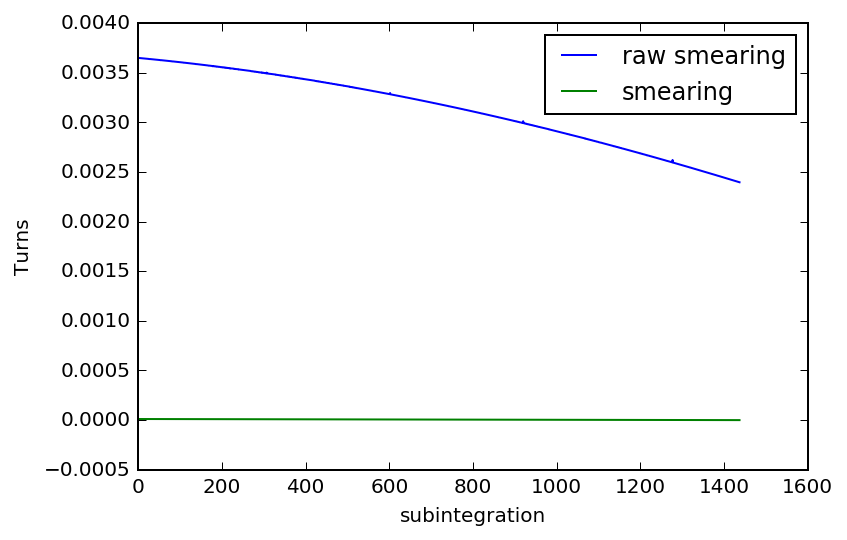

In [901]:
if "raw_smearing" in meta:
    plt.plot(meta["raw_smearing"][0], label="raw smearing")
    plt.plot(meta["smearing"][0], label="smearing")
    plt.legend(loc="best")
    plt.ylabel("Turns")
    plt.xlabel("subintegration")

In [904]:
meta["processing_name"] = processing_name
meta["template"] = os.path.basename(template)
meta["toa_name"] = toa_name

In [905]:
text_format = """PSR J0337+1715 observation {name}
Observed: {tel} {receiver} Processing: {processing_name} 
Template: {template} TOAs: {toa_name}
Center frequency: {centre_frequency:.1f} MHz
Length: {length:.1f} s Bandwidth: {bw:.1f} MHz
Maximum smearing: {max_smearing:.2f} $\mu$s
Signal-to-noise ratio overall: {overall_snr:.1f} Average: {average_snr:.1f}
RMS residual: {rms_residual:.2f} $\mu$s
Mean residual uncertainty: {mean_residual_uncertainty:.2f} $\mu$s
Residual reduced $\chi^2$: {reduced_chi2:.2f}
"""
summary["text_format"] = text_format

In [906]:
p_dir = join(observation,processing_name)
print p_dir
summary["p_dir"] = p_dir
scrunched = sorted(glob(join(p_dir, "scrunch_*.ar")))

T = psrchive.Archive_load(template)
T.dedisperse()
T.pscrunch()
T.remove_baseline()
t_values = convert_template(T.get_data()[0,0,0,:], meta["nbin"])
t_phases = np.linspace(0,1,len(t_values),endpoint=False)

snr_sum = 0
snr_weight = 0
snr_data = []

min_f = meta["centre_frequency"]-meta["bw"]/2
max_f = meta["centre_frequency"]+meta["bw"]/2
if min_f>max_f:
    min_f, max_f = max_f, min_f
summary["min_f"] = min_f
summary["max_f"] = max_f
    
for s in scrunched:
    F = psrchive.Archive_load(s)
    F.pscrunch()
    F.dedisperse()
    F.remove_baseline()
    # subint, chan, bin
    d = F.get_data()[:,0,:,:]
    w = F.get_weights()
    ns, nc, nb = d.shape
    snrs = np.ma.zeros((ns,nc))
    toa_by_index = {}
    subix = []
    for i in range(len(F)):
        I = F.get_Integration(i)
        subix.append(I.get_start_time().in_days())
    subix.append(I.get_end_time().in_days())
    subix = np.array(subix)
    chix = np.linspace(min_f, max_f, nc+1)
    for t in toa_info:
        i = np.searchsorted(subix,t["mjd"])-1
        j = np.searchsorted(chix,t["freq"])-1
        if meta["bw"] < 0:
            j = nc-1-j
        #print t["mjd"], t["freq"], i, j, min_f, max_f
        if (i,j) in toa_by_index:
            raise ValueError("Problem matching TOAs with subintegrations for %s" % t)
        toa_by_index[i,j] = t
    for i in range(ns):
        for j in range(nc):
            if w[i,j] == 0:
                snrs[i,j] = np.ma.masked
                continue
            prof_ = d[i,j]
            phase, amp, bg = align_scale_profile(t_values, prof_)
            t_fit = rotate_phase(t_values, phase)*amp + bg
            snrs[i,j] = np.sqrt(nb)*np.std(t_fit)/np.std(prof_-t_fit)
            if (i,j) in toa_by_index:
                toa_by_index[i,j]["flags"]["snr"] = snrs[i,j]
            else:
                raise ValueError("Missing TOA for unzapped subint (%d,%d)" % (i,j)) 
    ts = 0
    te = (F.end_time()-F.start_time()).in_days()*86400
    snr_data.append((ts,te,snrs))
    snr_sum += snrs.sum()
    snr_weight += snrs.count()
meta["average_snr"] = snr_sum/snr_weight
summary["snr_data"] = snr_data
summary["snr_sum"] = snr_sum
summary["snr_weight"] = snr_weight
summary["te"] = te

data/obs/56496.15_WSRT_1400/toa-testing-2


In [919]:
unscrunched = sorted(glob(join(p_dir, "zap_*.ar")))

gtp_data = None
gtp_weight = None
prof_data = None
prof_weight = None
std_data = None
std_weight = None

yfp_data = []
yfp_start_end = []

smear_data = []

for (i,u) in enumerate(unscrunched):    
    F = psrchive.Archive_load(u)
    F.convert_state('Stokes')
    F.dedisperse()
    F.remove_baseline()
    # axes are (subint, polarization, channel, bin)
    d = F.get_data()
    # axes are (subint, channel)
    w = F.get_weights()
    
    sm = meta["smearing"][i].copy()
    if "raw_smearing" in meta:
        sm += meta["raw_smearing"][i]
    sm_xs = np.linspace((F.start_time().in_days()-meta["tstart"])*86400,
                        (F.end_time().in_days()-meta["tstart"])*86400,
                        len(F)+1)[1:-1]
    smear_data.append((sm_xs,sm))
    if "max_smearing" not in meta:
        meta["max_smearing"] = 0
    meta["max_smearing"] = max(meta["max_smearing"],
                               np.amax(np.abs(sm))*1e6*meta["P"])
    
    # Profile
    sd, sw = np.ma.average(d, weights=w[:,None,:,None]+0*d, axis=2, returned=True)
    sd, sw = np.ma.average(sd, weights=sw, axis=0, returned=True)
    if prof_data is None:
        prof_data, prof_weights = sd, sw
    else:
        prof_data = (prof_data*prof_weights+sd*sw)/(prof_weights+sw)
        prof_weights += sw
    
    # Noise std. dev per bin (pre-averaging)
    sd = np.std(d[:,0,:,:], axis=-1)
    sd, sw = np.ma.average(sd,weights=w,returned=True)
    if std_data is None:
        std_data, std_weight = sd, sw
    else:
        std_data = (std_data*std_weight+sd*sw)/(std_weight+sw)
        std_weight += sw
    
    # GTp plot
    sd, sw = np.ma.average(d[:,0], weights=w[...,None]+0*d[:,0], axis=0, returned=True)
    if gtp_data is None:
        gtp_data, gtp_weights = sd, sw
    else:
        gtp_data = (gtp_data*gtp_weights+sd*sw)/(gtp_weights+sw)
        gtp_weights += sw
        
    # YFp plot
    yd, yw = np.ma.average(d[:,0], weights=w[...,None]+0*d[:,0], axis=1, returned=True)
    yd = np.ma.array(yd)
    yd[yw==0] = np.ma.masked
    b = (F.start_time().in_days()-meta["tstart"])*86400
    e = (F.end_time().in_days()-meta["tstart"])*86400
    yfp_data.append(yd)
    yfp_start_end.append((b,e))
gtp_data = np.ma.array(gtp_data)
gtp_data[gtp_weights==0] = np.ma.masked

phase, amp, bg = align_scale_profile(t_values, prof_data[0])
t_fit = rotate_phase(t_values, phase)*amp + bg
meta["overall_snr"] = np.sqrt(nb)*np.std(t_fit)/np.std(prof_data[0]-t_fit)
summary["gtp_data"] = gtp_data
summary["gtp_weights"] = gtp_weights
summary["yfp_data"] = yfp_data
summary["yfp_start_end"] = yfp_start_end
summary["smear_data"] = smear_data
summary["prof_data"] = prof_data
summary["prof_weights"] = prof_weights
summary["t_fit"] = t_fit

In [910]:
meta["summary"] = text_format.format(**meta)
print meta["summary"]


PSR J0337+1715 observation 56496.15_WSRT_1400
Observed: WSRT PuMa2_1400 Processing: toa-testing-2 
Template: 56736.85_AO_1400.profile.psrsmooth TOAs: normal
Center frequency: 1381.4 MHz
Length: 14389.9 s Bandwidth: 140.0 MHz
Maximum smearing: 10.00 $\mu$s
Signal-to-noise ratio overall: 143.2 Average: 29.0
RMS residual: 3.31 $\mu$s
Mean residual uncertainty: 2.32 $\mu$s
Residual reduced $\chi^2$: 1.35



In [911]:
# Weird that these are different.
for (b1,e1),(b2,e2) in zip(yfp_start_end[:-1], yfp_start_end[1:]):
    print e1, b2-e1

In [912]:
tdir = join(p_dir,meta["toa_name"])
if not os.path.exists(tdir):
    os.makedirs(tdir)
with open(join(tdir,"toas.tim"),"wt") as of:
    of.write("FORMAT 1\n")
    for t in toa_info:
        if "nch" in t["flags"]:
            del t["flags"]["nch"]
        for f in ["processing_name", "max_smearing", "band", "tel", "toa_name"]:
            t["flags"][f] = meta[f]

        flagpart = " ".join("-"+k+" "+str(v) for k,v in t["flags"].items())
        t["flagpart"] = flagpart
        l = "{file} {freq} {mjd_string} {uncert} {tel} {flagpart}".format(**t)
        of.write(l)
        print l
        of.write("\n")
with open(join(tdir,"toas.pickle"),"wt") as of:
    meta["toas"] = toa_info
    pickle.dump(meta, of)
with open(join(tdir,"summary.pickle"),"wt") as of:
    pickle.dump(summary, of)
    

data/obs/56496.15_WSRT_1400/toa-testing-2/scrunch_0000.ar 1381.167969 56496.066088085323441 2.354 wsrt -be PuMa2 -tel WSRT -tobs 600 -f unknown_PuMa2 -processing_name toa-testing-2 -band 1400 -bw 140 -snr 29.0661940092 -fe unknown -nbin 512 -toa_name normal -tmplt template-work/56736.85_AO_1400.profile.psrsmooth -max_smearing 10.0007718512
data/obs/56496.15_WSRT_1400/toa-testing-2/scrunch_0000.ar 1381.172607 56496.073032142562637 2.668 wsrt -be PuMa2 -tel WSRT -tobs 600 -f unknown_PuMa2 -processing_name toa-testing-2 -band 1400 -bw 140 -snr 25.8606073697 -fe unknown -nbin 512 -toa_name normal -tmplt template-work/56736.85_AO_1400.profile.psrsmooth -max_smearing 10.0007718512
data/obs/56496.15_WSRT_1400/toa-testing-2/scrunch_0000.ar 1381.16333 56496.079977170359885 2.532 wsrt -be PuMa2 -tel WSRT -tobs 600 -f unknown_PuMa2 -processing_name toa-testing-2 -band 1400 -bw 140 -snr 25.9785861841 -fe unknown -nbin 512 -toa_name normal -tmplt template-work/56736.85_AO_1400.profile.psrsmooth -ma

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,8)

lm = 0.085
prof = plt.axes((lm,0.70,0.4,0.25))
resid = plt.axes((lm,0.55,0.4,0.15))
gtp = plt.axes((lm,0.30,0.4,0.25))
yfp = plt.axes((lm,0.05,0.4,0.25))
text_x, text_y = 0.50, 0.95

cbar = plt.axes((0.80,0.70,0.15,0.03))
snr = plt.axes((0.55,0.55,0.4,0.15))
smear = plt.axes((0.55,0.40,0.4,0.15))
resid_t = plt.axes((0.55,0.25,0.4,0.15))
resid_f = plt.axes((0.55,0.05,0.4,0.15))

tend = (meta["tend"]-meta["tstart"])*86400

plt.sca(resid_t)
plt.errorbar((topo_toa-meta["tstart"])*86400, 1e6*resid2.prefit_sec, 1e6*resid2.uncertainty,
                linestyle="none", fmt="k.")
plt.xlabel("t (s)")
plt.ylabel("Residual ($\mu$s)")

plt.sca(resid_f)
plt.errorbar(resid2.bary_freq, 1e6*resid2.prefit_sec, 1e6*resid2.uncertainty,
            linestyle="none", fmt="k.")
plt.xlabel("f (MHz)")
plt.ylabel("Residual ($\mu$s)")

plt.sca(snr)
for ts, te, snrs in snr_data:
    if meta["bw"]>0:
        snrs = snrs[:,::-1]
    plt.imshow(snrs.T, extent=(ts, te, min_f, max_f),
          interpolation='nearest')
snr.set_aspect('auto')
plt.ylabel("f (MHz)")
plt.sca(resid_t)
plt.xlim(0,tend)
plt.sca(snr)
plt.tick_params(axis='x', labelbottom='off')
plt.xlim(0,tend)
cb = plt.colorbar(cax=cbar, orientation='horizontal', label="S/N")
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
plt.sca(smear)
plt.tick_params(axis='x', labelbottom='off')
plt.xlim(0,tend)
plt.ylabel("Smearing ($\mu$s)")

plt.sca(yfp)
#for (yd, (b,e)) in zip(yfp_data, yfp_start_end):
#    plt.imshow(yd[::-1,:],extent=(0,1,b,e),
#          interpolation='none')
yd = np.ma.concatenate(yfp_data)
b = yfp_start_end[0][0]
e = yfp_start_end[-1][1]
n, x = np.percentile(np.ma.compressed(yd),[1,99])
plt.imshow(yd[::-1,:],extent=(0,1,b,e),
           vmin=n, vmax=x,
      interpolation='none')
    
plt.sca(smear)
for (sm_xs, sm) in smear_data:
    plt.plot(sm_xs, sm*1e6*meta["P"], color='k')


plt.sca(prof)
ps = np.linspace(0,1,prof_data.shape[1],endpoint=False)
plt.plot(ps,prof_data[0,:], color='black')
plt.plot(ps,prof_data[3,:], color='blue')
plt.plot(ps,np.hypot(prof_data[1,:],prof_data[2,:]), color='red')
plt.plot(ps, t_fit, color='green')
#plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
plt.tick_params(axis='x', labelbottom='off')
plt.ylabel("Flux density (Jy?)")
p_x = ps[np.argmax(t_fit)]
vline_alpha = 0.5
vline_color = 'purple'
plt.axvline(p_x, color=vline_color, alpha=vline_alpha)
plt.xlim(0,1)

plt.sca(resid)
plt.plot(ps,prof_data[0,:]-t_fit, color='black')
plt.ylabel(r"$\Delta$Flux")
plt.tick_params(axis='x', labelbottom='off')
plt.axvline(p_x, color=vline_color, alpha=vline_alpha)
plt.xlim(0,1)

plt.sca(gtp)
if meta["bw"]<0:
    gtp_data_display = gtp_data[::-1,:]
else:
    gtp_data_display = gtp_data
n, x = np.percentile(np.ma.compressed(gtp_data),[1,99])
plt.imshow(gtp_data_display[::-1,:], extent=(0,1,min_f,max_f),
           vmin=n, vmax=x,
          interpolation='none')
gtp.set_aspect("auto")
plt.ylabel("freq (MHz)")
plt.tick_params(axis='x', labelbottom='off')
plt.axvline(p_x, color=vline_color, alpha=vline_alpha)
plt.xlim(0,1)

plt.sca(yfp)
yfp.set_aspect("auto")
plt.xlabel("pulse phase")
plt.ylabel("time (s)")
plt.axvline(p_x, color=vline_color, alpha=vline_alpha)
plt.xlim(0,1)
plt.ylim(0,(meta["tend"]-meta["tstart"])*86400)

plt.sca(resid_f)
plt.xlim(min_f, max_f)

text = text_format.format(**meta)

print text
plt.text(text_x, text_y, text, 
         horizontalalignment="left", verticalalignment="top",
         transform=fig.transFigure)


plt.viridis()
plt.savefig(join(tdir,"summary.pdf"))

In [ ]:
tdir

In [ ]:
sorted(os.listdir(tdir))

In [ ]:
print open(join(tdir,"toas.tim")).read()

In [2]:
observation = "data/obs/55962.26_GBT_1400"
processing_name = "wideband"
template = "template-work/56736.85_AO_1400.profile.psrsmooth"
toa_name = "toa-testing-3"

In [5]:
with open(join(observation,processing_name,"process.pickle"),"rb") as f:
    meta = pickle.load(f)
summary = dict(meta=meta)
#print meta["observation"], observation
meta["observation"] = observation
meta["processing_name"] = processing_name
meta["template"] = os.path.basename(template)
meta["template_path"] = template
meta["toa_name"] = toa_name
text_format = """PSR J0337+1715 observation {name}
Observed: {tel} {receiver} Processing: {processing_name} 
Template: {template} TOAs: {toa_name}
Center frequency: {centre_frequency:.1f} MHz
Length: {length:.1f} s Bandwidth: {bw:.1f} MHz
Maximum smearing: {max_smearing:.2f} $\mu$s
Signal-to-noise ratio overall: {overall_snr:.1f} Average: {average_snr:.1f}
RMS residual: {rms_residual:.2f} $\mu$s
Mean residual uncertainty: {mean_residual_uncertainty:.2f} $\mu$s
Residual reduced $\chi^2$: {reduced_chi2:.2f}
"""
summary["text_format"] = text_format

In [10]:
pipe.prepare_toa_info(summary)

scrunched file: data/obs/55962.26_GBT_1400/wideband/scrunch_0000.ar
pat output: 'FORMAT 1\n'
TOAs: 0


IOError: [Errno 2] No such file or directory: '/tmp/tmpgw_Xkhtriple/resid2.tmp'

In [ ]:
pipe.prepare_scrunched(summary)

In [ ]:
pipe.prepare_unscrunched(summary)
meta["summary"] = text_format.format(**meta)

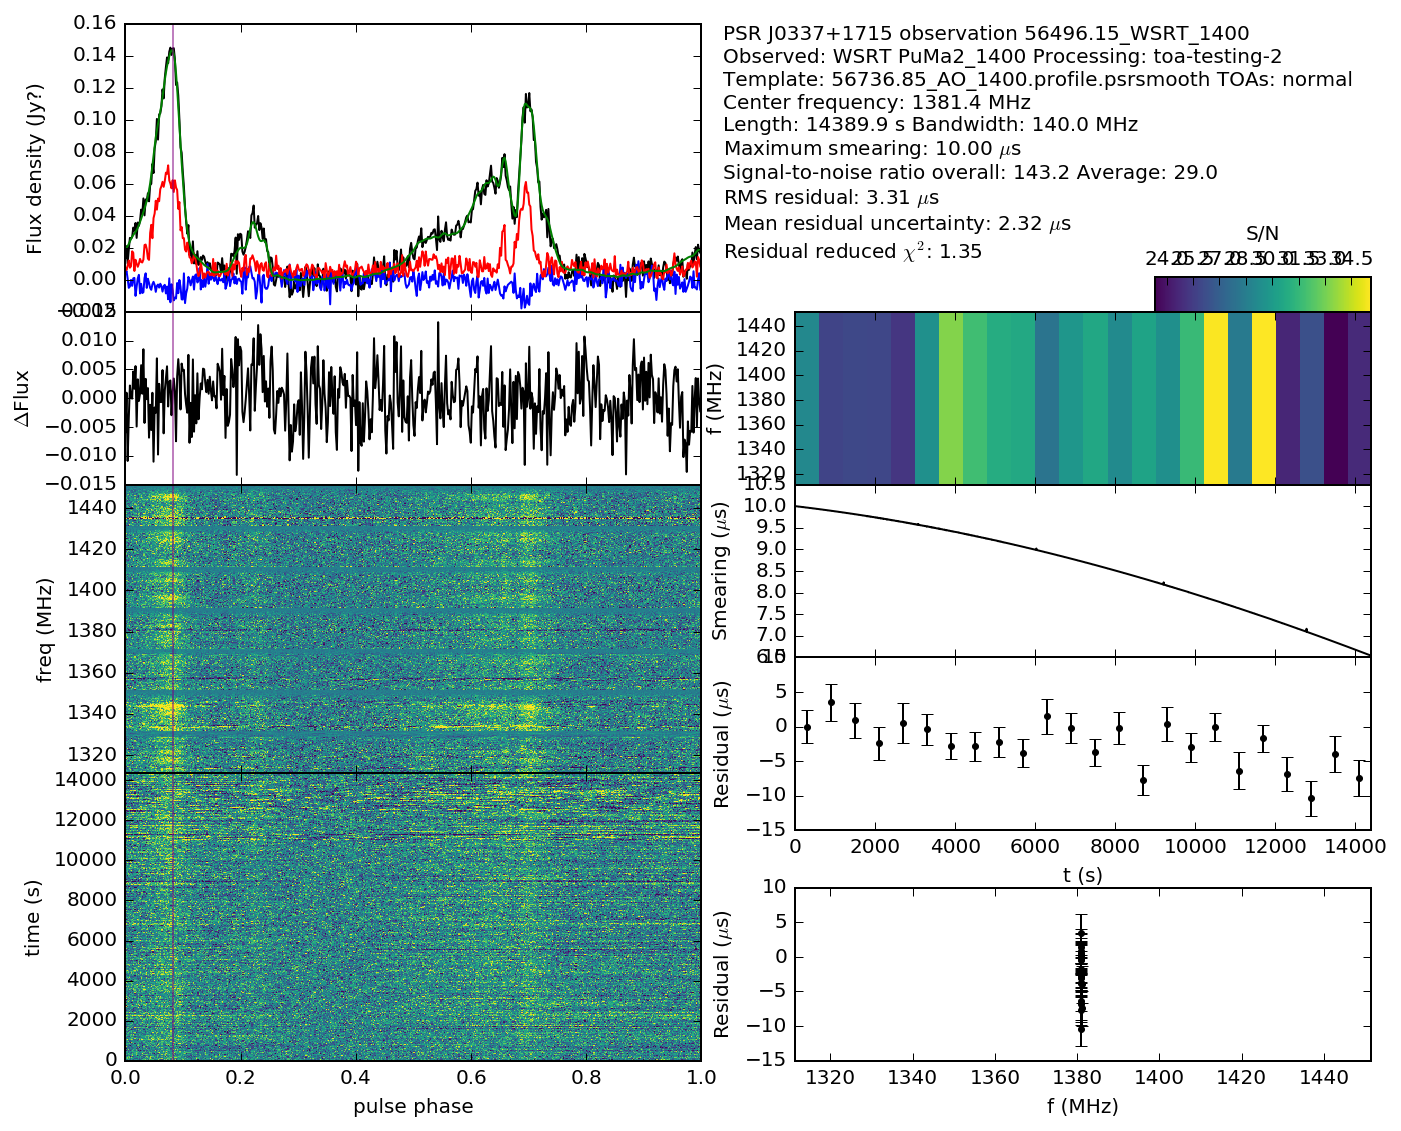

In [936]:
pipe.plot_summary(summary)

In [932]:
meta.keys()

['tel',
 'rms_residual',
 'template_path',
 'scrunch_nchan',
 'nbin',
 'summary',
 'calibration_type',
 'average_snr',
 'overall_snr',
 'work_dir',
 'toa_name',
 'obs_dir',
 'tend',
 'tstart',
 'toas',
 'max_smearing',
 'template',
 'raw_files',
 'P',
 'bw',
 'smearing',
 'input_files',
 'mjd',
 'nchan',
 'name',
 'centre_frequency',
 'band',
 'processing_name',
 'mean_residual_uncertainty',
 'reduced_chi2',
 'length',
 'nsubint',
 'scrunch_nsubint',
 'receiver',
 'observation',
 'raw_smearing']

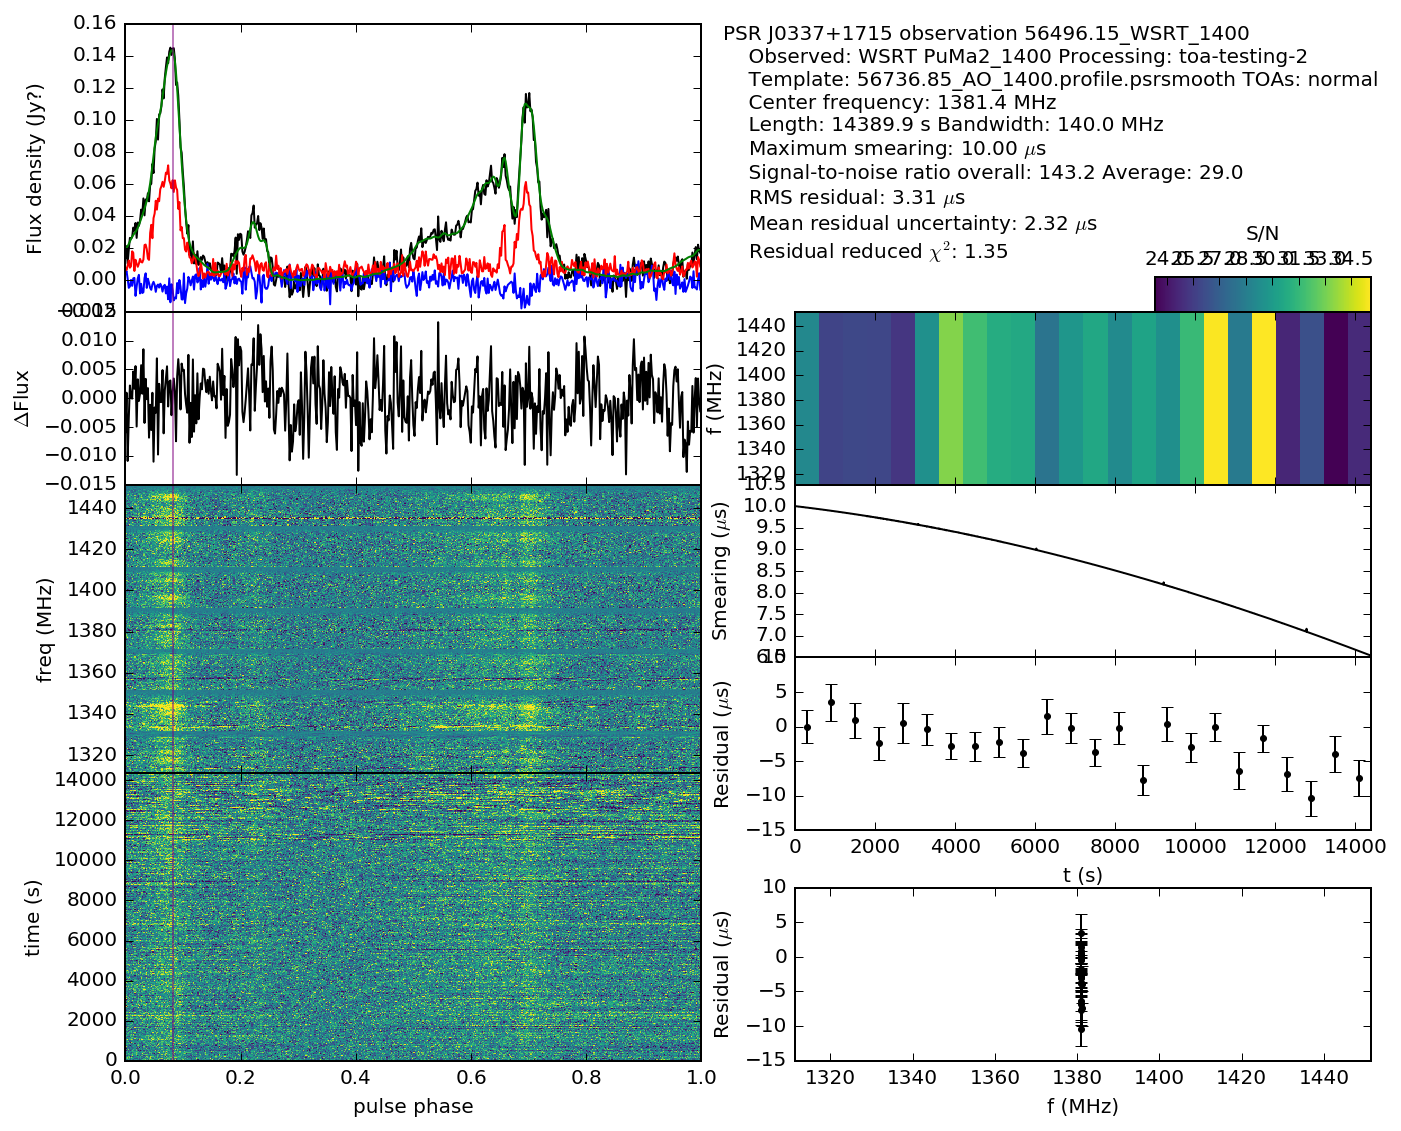

In [947]:
pipe.make_toas(observation, processing_name, toa_name, template)